In [136]:
import numpy as np
import scipy.linalg as lin
from scipy.linalg import cho_factor, cho_solve, inv

def ACE(M, t):
    """
    Performs the adaptive cosin/coherent estimator algorithm for target
    detection.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

        t: `numpy array`
            A target endmember (p).

    Returns: `numpy array`
        Vector of detector output (N).

    References:
      X Jin, S Paswater, H Cline.  "A Comparative Study of Target Detection
      Algorithms for Hyperspectral Imagery."  SPIE Algorithms and Technologies
      for Multispectral, Hyperspectral, and Ultraspectral Imagery XV.  Vol
      7334.  2009.
    """
    N, p = M.shape
    # Remove mean from data
    u = M.mean(axis=0)
    print(u[0])
    print(u.shape)
    print(np.kron(np.ones((N, 1)), u).shape)
    M = M - np.kron(np.ones((N, 1)), u)
    print(M.dtype)
    print(M[0][0])
    t = t - u;
    print(t.dtype)
    print(t[0])

    R_hat = np.cov(M.T).astype(np.float32)
    print(R_hat[0][0].item())
    print(R_hat.dtype)
    G = lin.inv(R_hat.astype(np.float32))
    
    print(G)
    print(G[0][0])
    print(G.dtype)

    results = np.zeros(N, dtype=np.float32)
    print(results[0])
    ##% From Broadwater's paper
    ##%tmp = G*S*inv(S.'*G*S)*S.'*G;
    tmp = np.array(np.dot(t.T, np.dot(G, t)))
    print(tmp)
    dot_G_M = np.dot(G, M[0:,:].T)
    print(dot_G_M[0][0])
    num = np.square(np.dot(t, dot_G_M))
    print(num[0])
    for k in range(N):
        denom = np.dot(tmp, np.dot(M[k], dot_G_M[:,k]))
        results[k] = num[k] / denom
    print(results[0])
    return results
def ACE_sped_up(M, t):
    """
    Optimized Adaptive Coherent Estimator (ACE) using Cholesky decomposition.
    """
    N, p = M.shape
    # Remove mean
    u = M.mean(axis=0)
    M = M - u
    t = t - u

    # Estimate covariance and compute its inverse using Cholesky decomposition
    R_hat = np.cov(M, rowvar=False)
    L, lower = cho_factor(R_hat, lower=True)  # Cholesky decomposition
    Gt = cho_solve((L, lower), t)  # Solve G @ x = t
    GM = cho_solve((L, lower), M.T)  # Solve G @ X = M.T

    # Compute ACE score
    tmp = t @ Gt  # Scalar
    num = (t @ GM) ** 2  # Vectorized numerator
    denom = tmp * np.einsum('ij,ji->i', M, GM)  # Vectorized denominator

    return num / denom

0.5048751388595808


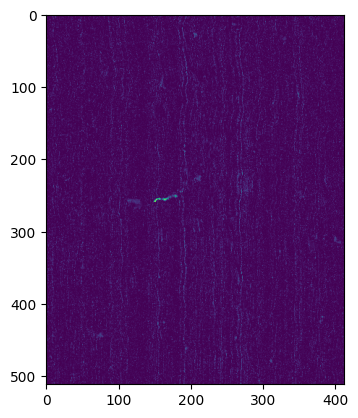

In [137]:
import numpy as np
import matplotlib.pyplot as plt
tile = np.load("test_tile.npy")[:,100:,:]
H,W,C = tile.shape
transmittance = np.load("test_transmittance.npy").astype(np.float32)
tile_flatten = tile.reshape((-1, C))
ace_result = ACE_sped_up(tile_flatten, transmittance)
ace_tile = ace_result.reshape((H,W))
plt.imshow(ace_tile)
print(ace_result.max())

In [155]:
import torch
import torch.nn as nn

class ACEModel(nn.Module):
    def __init__(self):
        super(ACEModel, self).__init__()

    def forward(self, M, t):
        """
        Optimized Adaptive Coherent Estimator (ACE) using Cholesky decomposition in PyTorch.
        """
        N, p = M.shape
        # Remove mean
        u = torch.mean(M, dim=0)
        M_centered = M - u
        t_centered = t - u

        # Estimate covariance matrix
        R_hat = torch.cov(M_centered.T, correction=1)
        
        # Cholesky decomposition
        L = torch.linalg.cholesky(R_hat)
        
        # Solve for Gt and GM
        Gt = torch.cholesky_solve(t_centered.unsqueeze(1), L).squeeze(1)  # [p]
        GM = torch.cholesky_solve(M_centered.T, L)  # [p, N]
        
        # Compute ACE scores
        tmp = torch.dot(t_centered, Gt)  # Scalar
        num = torch.matmul(t_centered, GM).pow(2)  # [N]
        denom = tmp * (M_centered * GM.T).sum(dim=1)  # [N]
        
        return num / denom
        """
        Performs the Adaptive Coherent Estimator (ACE) algorithm for target detection.

        Parameters:
            M: `torch.Tensor`
                2D matrix of HSI data (N x p).

            t: `torch.Tensor`
                A target endmember (p).

        Returns: `torch.Tensor`
            Vector of detector output (N).
        """
        N, p = M.shape
        
        # Remove mean from data
        u = M.mean(dim=0, keepdim=True).squeeze()
        print(u[0])
        M_centered = M - u
        print(M_centered[0][0])
        t_centered = t - u.squeeze()
        print(t_centered[0])
        
        # Compute covariance matrix
        R_hat = torch.cov(M_centered.T)
        print(R_hat[0][0].item())
        print(R_hat.dtype)

        # Perform Cholesky decomposition (lower triangular matrix L)
        L = torch.linalg.cholesky(R_hat)

        # Solve G @ x = t, i.e., Gt = L^{-1} t (using forward substitution)
        L_inv_t = torch.linalg.inv(L) @ t

        # Solve G @ X = M.T, i.e., GM = L^{-1} M.T (using forward substitution)
        L_inv_MT = torch.linalg.inv(L) @ M.T

        # Compute ACE score
        tmp = torch.dot(t, L_inv_t)  # Scalar value for the numerator of the ACE score
        num = torch.square(torch.dot(t, L_inv_MT))  # Vectorized numerator (squared dot product)
        denom = tmp * torch.sum(M * L_inv_MT.T, dim=1)  # Vectorized denominator
        print(R_hat.dtype)

        """#G = torch.linalg.inv(R_hat)
        #G = lin.inv(R_hat)

        P, L, U = torch.linalg.lu(R_hat)
        G = torch.linalg.inv(U) @ torch.linalg.inv(L) @ P.T
        print(G)
        print(G[0][0])
        print(G.dtype)
        
        # Compute the numerator
        tmp = torch.dot(t_centered, G @ t_centered)
        print(tmp)
        dot_G_M = G @ M_centered.T
        print(dot_G_M[0][0])
        num = (t_centered @ dot_G_M).square()
        print(num[0])
        # Compute the denominator
        denom = tmp * torch.sum(M_centered * dot_G_M.T, dim=1)
        #denom = tmp * (M_centered @ dot_G_M.T).diag()
        # Compute ACE scores
        results = num / denom
        print(results[0])"""
        print(R_hat.dtype)
        results = num / denom
        print(R_hat.dtype)
        return results
    

    

(210944, 72)
tensor(0.4965)


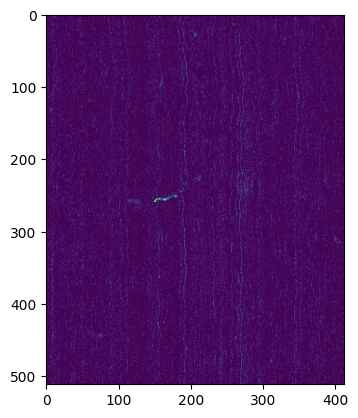

In [156]:
#inference
# Create an instance of the ACE model
ace_model = ACEModel()
print(tile_flatten.shape)
model_result = ace_model(torch.from_numpy(tile_flatten), torch.from_numpy(transmittance))
print(model_result.max())

plt.imshow(model_result.reshape((H,W)))

In [154]:

# Sample input tensors (random for testing)
N, p = 512, 200  # Example dimensions
M_sample = torch.randn(N, p, dtype=torch.float32)
t_sample = torch.randn(p, dtype=torch.float32)

# Convert to ONNX
torch.onnx.export(
    ace_model,
    (M_sample, t_sample),  # Input tuple
    "ace_model.onnx",
    input_names=["M", "t"],
    output_names=["ace_output"],
    dynamic_axes={
        "M": {0: "N"},  # Allow N to be dynamic
        "ace_output": {0: "N"}  # Output should also be dynamic
    },
    opset_version=11  # ONNX opset version
)

UnsupportedOperatorError: Exporting the operator 'aten::linalg_cholesky' to ONNX opset version 11 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

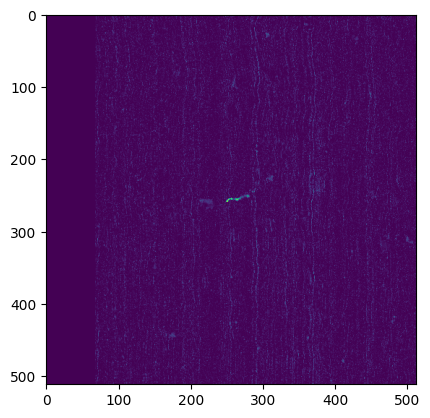

In [ ]:
ace_original = "blah/ang20191025t171141_r10528_c126_w151_h151/ace.npy"
print
plt.imshow(np.load(ace_original))